<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Model_WithoutKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math
from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow
from tensorflow.python.tools import inspect_checkpoint as ckpt 



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
#FEATURES AND LABELS  
 
with open('/content/NonHDR_Features.bin','rb') as file:
  f = pickle.load(file)
  
  
with open('/content/NonHDR_Labels.bin','rb') as file:
  l = pickle.load(file)

In [3]:
print(np.shape(f))
print(type(f))

(2539, 10)
<class 'list'>


In [0]:
features = []
labels = []

for i in f:
  features.append(list(map(float,i)))
for i in l:
  labels.append(list(map(float,i)))

In [0]:
x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [7]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2097464469789091273
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5360027062066962914
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13826943759781377241
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11228853837738388849
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [8]:
x = tf.placeholder(shape = (None,10), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

#Layer 1 
w1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((10, 15))), name = 'w1')
b1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,15))), name = 'b1')

#Layer2 

w2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((15,25))), name = 'w2')
b2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,25))), name = 'b2')

#out

wo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((25,1))), name = 'wo')
bo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,1))), name = 'bo')


W0831 14:42:42.162469 140396757149568 deprecation.py:506] From <ipython-input-8-efd924619411>:5: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0831 14:42:42.163739 140396757149568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
hidl1 = tf.add(tf.matmul(x,w1),b1, name ='hidden1')
hidl1 = tf.nn.relu(hidl1)
hidl2 = tf.add(tf.matmul(hidl1,w2),b2, name = 'hidden2')
hidl2 = tf.nn.relu(hidl2)
out = tf.add(tf.matmul(hidl2,wo),bo,name = 'output')


In [0]:
## MSE - Loss function
loss = tf.reduce_mean(tf.square(tf.subtract(y,out))) 

## Optimizer - Adam
opt = tf.train.AdamOptimizer(name = 'optimizer', learning_rate=0.005)
op_train = opt.minimize(loss, name ='train_op')


In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

3977.3777	3806.5063
5471.5083	3487.1155
3062.966	3240.8972
3733.1975	3159.6372
4336.4805	4467.617
3344.8062	3383.838
2183.4885	4946.3647
4216.4067	3446.118
3099.5125	3820.3496
2586.9631	3984.3125
3547.628	3865.9302
2058.07	3854.7532
4010.836	3669.1182
5414.6357	4485.293
2335.234	3266.7249
3078.43	4254.677
4435.3066	2708.6802
4491.6616	3656.6377
3727.4663	2817.917
3044.373	3747.793
3781.4302	3313.9658
5664.802	2038.4688
5295.722	2134.8628
2333.7546	2957.1904
3465.8193	3207.6294
2965.258	3600.2773
4540.1577	2641.8074
2902.833	4844.056
3517.485	3545.2964
2736.5562	1804.2278
2286.6345	2286.2915
2649.8474	3049.0737
3886.4392	2531.6753
2258.8142	1476.3806
1960.2886	2215.658
1714.5182	3470.6475
1449.6631	2081.83
3212.2214	1904.0525
3010.687	2317.3413
4263.4004	1947.704
2227.2222	3824.888
2246.555	2380.942
1513.8995	1471.8613
2315.6714	1793.6978
1826.3524	1163.7351
2218.4597	1724.7438
2736.5293	989.22424
2066.4766	896.6571
1041.0052	668.1522
736.2761	801.658
582.5064	378.84927
354.38684	1191.5

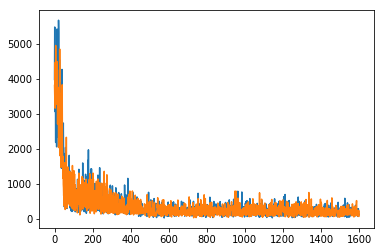

In [13]:

train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    #saved.restore(sess, "/content/final_check_weights.ckpt")
    mini =[]
    for i in range(1600):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    save_path = save.save(sess, "/content/final_TBP.ckpt")
    print('Saved model!')
    
 

In [14]:
val = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, '/content/final_TBP.ckpt')
    val.append(sess.run('output',feed_dict={x : x_batch}))
    


W0831 14:42:56.011871 140396757149568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [19]:
print(type(tf.get_default_graph().as_graph_def()))
tf.io.write_graph(tf.get_default_graph().as_graph_def(), '/content/', 'Final_Graph.pbtxt')

<class 'tensorflow.core.framework.graph_pb2.GraphDef'>


'/content/Final_Graph.pbtxt'

In [0]:
with open('/content/Final_Graph.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())
  

Restoration Files (No need to run these unless required for additional analysis)

In [0]:
with open('/content/x_test.bin','wb') as file:
  pickle.dump(x_test_t, file)
with open('/content/y_test.bin','wb') as file:
  pickle.dump(y_test_t, file)